In [30]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.utils.np_utils import to_categorical
from matplotlib.ticker import MaxNLocator
from sklearn import metrics
import time

In [31]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = np.transpose(x_train, (0, 3, 2, 1)) / 255.0
x_test = np.transpose(x_test, (0, 3, 2, 1)) / 255.0
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [42]:
class Layer:
    def forward(self, params, training=True):
        raise NotImplementedError

    def backward(self, backward):
        raise NotImplementedError

    def update_params(self, iteration, learning_rate, beta1=0.9, beta2=0.999):
        return


class Convolutional_layer(Layer):
    def __init__(self, kernel_num, kernel_size, dimensionOfSample):
        self.input = None
        self.kernel_num = kernel_num
        self.kernel_size = kernel_size
        self.bias = np.zeros(kernel_num)
        self.kernels = np.random.randn(kernel_num, dimensionOfSample, kernel_size, kernel_size) * np.sqrt(
            2 / (dimensionOfSample * kernel_size ** 2))
        self.kernels_m = np.zeros_like(self.kernels)
        self.bias_m = np.zeros_like(self.bias)
        self.kernels_v = np.zeros_like(self.kernels)
        self.bias_v = np.zeros_like(self.bias)

    def forward(self, forwardInput, training=True):
        self.input = forwardInput
        self.conv_output = np.zeros(
            (self.input.shape[0], self.kernel_num, self.input.shape[2], self.input.shape[3]))
        paddedInput = np.pad(forwardInput, [(0, 0), (0, 0), (1, 1), (1, 1)], mode='constant')

        tmpInput = np.lib.stride_tricks.sliding_window_view(paddedInput, (self.kernel_size, self.kernel_size), axis=(2, 3))
        self.conv_output = np.einsum('ijklmn,ojmn->iokl', tmpInput, self.kernels, optimize='greedy') + self.bias[None, :, None, None]

        return self.conv_output

    def backward(self, dLdZ):
        dX = np.zeros_like(self.input, dtype=float)
        self.dF = np.zeros_like(self.kernels, dtype=float)
        paddedInput = np.pad(self.input, [(0, 0), (0, 0), (1, 1), (1, 1)], mode='constant')
        flipped_kernel = np.flip(self.kernels, (2, 3))
        paddedOutput = np.pad(dLdZ, [(0, 0), (0, 0), (1, 1), (1, 1)], mode="constant")

        tmpIn = np.lib.stride_tricks.sliding_window_view(paddedInput, (dLdZ.shape[2], dLdZ.shape[2]), axis=(2, 3))
        self.dF = np.einsum('ijklmn,iomn->ojkl', tmpIn, dLdZ, optimize='greedy')

        tmpOut = np.lib.stride_tricks.sliding_window_view(paddedOutput, (self.kernel_size, self.kernel_size), axis=(2, 3))
        dX = np.einsum('ijklmn,jomn->iokl', tmpOut, flipped_kernel, optimize='greedy')

        self.dB = np.einsum('ijkl->j', dLdZ)
        return dX

    def update_params(self, iteration, learning_rate, beta1=0.9, beta2=0.999):
        self.kernels_m = beta1 * self.kernels_m + (1 - beta1) * self.dF
        self.bias_m = beta1 * self.bias_m + (1 - beta1) * self.dB
        kernels_m_hat = self.kernels_m / (1 - beta1 ** (iteration + 1))
        bias_m_hat = self.bias_m / (1 - beta1 ** (iteration + 1))
        self.kernels_v = beta2 * self.kernels_v + (1 - beta2) * self.dF ** 2
        self.bias_v = beta2 * self.bias_v + (1 - beta2) * self.dB ** 2
        kernels_v_hat = self.kernels_v / (1 - beta2 ** (iteration + 1))
        bias_v_hat = self.bias_v / (1 - beta2 ** (iteration + 1))

        self.kernels -= learning_rate * kernels_m_hat / (np.sqrt(kernels_v_hat) + 1e-6)
        self.bias -= learning_rate * bias_m_hat / (np.sqrt(bias_v_hat) + 1e-6)


class MaxPoolingLayer(Layer):
    def patches_generator(self, input):
        image_sample, image_channels, image_h, image_w = input.shape
        self.image = input
        for h in range(image_h // 2):
            for w in range(image_w // 2):
                patch = input[:, :, 2 * h:2 * h + 2, 2 * w:2 * w + 2]
                yield patch, h, w

    def forward(self, ForwardInput, training=True):
        self.input = ForwardInput
        self.mask = np.zeros_like(ForwardInput, dtype=float)
        self.forward_output = np.zeros(
            (ForwardInput.shape[0], ForwardInput.shape[1], ForwardInput.shape[2] // 2, ForwardInput.shape[3] // 2),
            dtype=float)
        for patch, h, w in self.patches_generator(self.input):
            max = np.max(patch, axis=(2, 3), keepdims=True)
            expanded_max = np.repeat(np.repeat(max, 2, axis=2), 2, axis=3)
            self.forward_output[:, :, h:h + 1, w:w + 1] = max
            self.mask[:, :, 2 * h:2 * h + 2, 2 * w:2 * w + 2] = np.equal(expanded_max, self.input[:, :, 2 * h:2 * h + 2,
                                                                                       2 * w:2 * w + 2]).astype(int)
        return self.forward_output

    def backward(self, backward):
        backward_repeated = np.repeat(np.repeat(backward, 2, axis=2), 2, axis=3)
        return np.array(backward_repeated * self.mask, dtype='float32')


class ReLU(Layer):
    def forward(self, Z, training=True):
        self.Z = Z
        return np.where(Z > 0, Z, 0)

    def backward(self, dLdA):
        return np.where(self.Z > 0, 1, 0) * dLdA


class LeakyReLU(Layer):
    def __init__(self, alpha=0.01):
        self.alpha = alpha
        self.input = None

    def forward(self, X, training=True):
        self.input = X
        return np.where(X >= 0, X, self.alpha * X)

    def backward(self, dLdA):
        return np.where(self.input >= 0, dLdA, self.alpha * dLdA)


class Flatten(Layer):
    def forward(self, A, training=True):
        self.N, self.C, self.H, self.W = A.shape
        reshaped = np.zeros((self.C * self.H * self.W, self.N), dtype='float32')
        for i in np.arange(0, self.N):
            reshaped[:, i:i + 1] = np.reshape(A[i], (self.C * self.H * self.W, 1))
        return reshaped

    def backward(self, dLdS):
        back_shape = np.zeros((self.N, self.C, self.H, self.W), dtype='float32')
        for i in np.arange(0, dLdS.shape[1]):
            back_shape[i:i + 1] = np.reshape(dLdS[:, i:i + 1], (self.C, self.H, self.W))
        return back_shape


class Linear(Layer):
    def __init__(self, m, n):
        self.dLdW0 = None
        self.dLdW = None
        self.A = None
        self.m, self.n = (m, n)
        self.W0 = np.zeros([n, 1])
        self.W = np.random.randn(m, n) * np.sqrt(2 / m)
        self.weight_m = np.zeros_like(self.W)
        self.bias_m = np.zeros_like(self.W0)
        self.weight_v = np.zeros_like(self.W)
        self.bias_v = np.zeros_like(self.W0)

    def forward(self, A, training=True):
        self.A = A
        return np.transpose(self.W) @ self.A + self.W0

    def backward(self, dLdZ):
        self.dLdW = self.A @ np.transpose(dLdZ)
        self.dLdW0 = np.sum(dLdZ, axis=1, keepdims=True)
        return self.W @ dLdZ

    def update_params(self, iteration, learning_rate, beta1=0.9, beta2=0.999):
        self.weight_m = beta1 * self.weight_m + (1 - beta1) * self.dLdW
        self.bias_m = beta1 * self.bias_m + (1 - beta1) * self.dLdW0
        weight_m_hat = self.weight_m / (1 - beta1 ** (iteration + 1))
        bias_m_hat = self.bias_m / (1 - beta1 ** (iteration + 1))
        self.weight_v = beta2 * self.weight_v + (1 - beta2) * self.dLdW ** 2
        self.bias_v = beta2 * self.bias_v + (1 - beta2) * self.dLdW0 ** 2
        weight_v_hat = self.weight_v / (1 - beta2 ** (iteration + 1))
        bias_v_hat = self.bias_v / (1 - beta2 ** (iteration + 1))

        self.W -= learning_rate * weight_m_hat / (np.sqrt(weight_v_hat) + 1e-10)
        self.W0 -= learning_rate * bias_m_hat / (np.sqrt(bias_v_hat) + 1e-10)


class SoftMax(Layer):
    def forward(self, Z, training=True):
        values = np.exp(Z)
        return values / np.sum(values, axis=0, keepdims=True)

    def backward(self, dLdZ):
        return dLdZ

    def class_fun(self, Ypred):
        return np.argmax(Ypred, axis=0)

class Dropout(Layer):
    def __init__(self, dropout_rate):
        self.dropout_rate = dropout_rate

    def forward(self, X, training=True):
        if training:
            self.mask = np.random.binomial(1, 1 - self.dropout_rate, size=X.shape[1:]) / (1 - self.dropout_rate)
            return X * self.mask
        else:
            return X

    def backward(self, dA):
        return dA * self.mask

def CrossEntropy_forward(Ypred, Y):
    return np.sum(-Y * np.log(Ypred + 1e-10))


def CrossEntropy_backward(Ypred, Y):
    return Ypred - Y


class Network:
    def __init__(self, layers):
        self.layers = layers
        self.iteration = 0
        self.learning_rate = 0.005

    def update_layer_params(self):
        self.iteration += 1
        for m in self.layers:
            m.update_params(self.iteration, self.learning_rate)

    def forward(self, Xt, training):
        for m in self.layers:
            Xt = m.forward(Xt, training)
        return Xt

    def backward(self, loss):
        for m in reversed(self.layers):
            loss = m.backward(loss)

    def train(self, X, Y, training=True):
        Ypred = self.forward(X, training)
        err = CrossEntropy_backward(Ypred, Y)
        sum_loss = CrossEntropy_forward(Ypred, Y)
        self.backward(err)
        self.update_layer_params()
        acc_training, max_index_pred, max_index_original = self.predictionAccuracy(Ypred, Y)
        return acc_training, sum_loss

    def predictionAccuracy(self, Ypred, Y):
        max_index_pred = self.layers[-1].class_fun(Ypred)
        max_index_original = self.layers[-1].class_fun(Y)
        acc = np.sum(np.equal(max_index_pred, max_index_original).astype(int))
        return acc, max_index_pred, max_index_original

    def predict(self, X, Y):
        Ypred = self.forward(X, training=False)
        acc, max_index_pred, max_index_original = self.predictionAccuracy(Ypred, Y)
        loss = CrossEntropy_forward(Ypred, Y)
        return acc, loss, max_index_pred, max_index_original

    def batch_gradient_descent(self, X_train, Y_train, X_test, Y_test, epochs, batch_size, learning_rate):
        self.learning_rate = learning_rate
        validation_X = X_train[40000:]
        validation_Y = Y_train[40000:]
        X_train = X_train[:40000]
        Y_train = Y_train[:40000]
        validation_loss = []
        validation_acc = []
        train_loss = []
        train_acc = []
        for epochs in range(epochs):
            train_loss_batches = []
            train_acc_batches = []
            mini_batch_X, mini_batch_Y = self.mini_batch_generator(X_train, Y_train, 64)
            for data, label in zip(mini_batch_X, mini_batch_Y):
                acc, loss = self.train(data, label.T, training=True)
                train_loss_batches.append(loss)
                train_acc_batches.append(acc)
            train_loss.append(np.sum(train_loss_batches, dtype='float32') / 40000.0)
            train_acc.append(np.sum(train_acc_batches, dtype='float32') / 40000.0)
            accVal = 0
            lossVal = 0
            for i in range(20):
              acc, loss, max_index_pred, max_index_original = self.predict(validation_X[i*500:(i+1)*500], validation_Y.T[:, i*500:(i+1)*500])
              accVal+=acc
              lossVal+=loss
            validation_acc.append(accVal/10000.0)
            validation_loss.append(lossVal/10000.0)
            print('Epoch: ' + str(epochs+1) + '   ' + 'Training loss: ' + str(train_loss[epochs]) + '   ' + 'Training accuracy: ' + str(train_acc[epochs]) + '   ' +
                  'Validation loss: ' + str(validation_loss[epochs]) + '   ' + 'Validation accuracy: ' + str(validation_acc[epochs]))

        fig, axs = plt.subplots(1, 2, figsize=(15, 5))
        fig.suptitle('Loss and accuracy')
        axs[0].set_title("Loss")
        axs[0].plot(train_loss, label='Training loss')
        axs[0].plot(validation_loss, label='Validation loss')
        axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))
        axs[1].set_title("Accuracy")
        axs[1].plot(train_acc, label='Training accuracy')
        axs[1].plot(validation_acc, label='Validation accuracy')
        axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))
        for ax in axs:
            ax.legend()
            ax.set_xlabel('Number of epochs')
        plt.show()
        accTest = 0
        lossTest = 0
        max_index_predicted = None
        max_index_original = None
        for i in range(20):
          acc, loss, max_index_pred, max_index_orig = self.predict(X_test[i*500:(i+1)*500], Y_test.T[:, i*500:(i+1)*500])
          accTest += acc
          lossTest += loss
          if i == 0:
            max_index_predicted = np.array(max_index_pred)
            max_index_original = np.array(max_index_orig)
          else:
            max_index_predicted = np.concatenate((max_index_predicted, np.array(max_index_pred)))
            max_index_original = np.concatenate((max_index_original, np.array(max_index_orig)))
        print("The test accuracy: " + str(accTest/10000.0) + ".  " + "The test loss: " + str(lossTest/10000.0) + ".")
        confusion_matrix = metrics.confusion_matrix(max_index_original, max_index_predicted)
        class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                       'dog', 'frog', 'horse', 'ship', 'truck']
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=class_names)
        cm_display.plot()
        fig = cm_display.ax_.get_figure()
        fig.set_figwidth(8)
        fig.set_figheight(6)
        plt.show()

    def mini_batch_generator(self, train_X, train_Y, batch_size):
        num_data = train_X.shape[0]
        num_batch = num_data // batch_size

        indices = np.random.permutation(num_data)
        train_X = train_X[indices]
        train_Y = train_Y[indices]
        mini_batch_X = np.array(np.split(train_X, num_batch, axis=0))
        mini_batch_Y = np.array(np.split(train_Y, num_batch, axis=0))
        return mini_batch_X, mini_batch_Y

Epoch: 1   Training loss: 1.7891345703125   Training accuracy: 0.333325   Validation loss: 1.6680247703235755   Validation accuracy: 0.3888
Epoch: 2   Training loss: 1.600926171875   Training accuracy: 0.410475   Validation loss: 1.6168820701381876   Validation accuracy: 0.408
Epoch: 3   Training loss: 1.5324810546875   Training accuracy: 0.438275   Validation loss: 1.5435608131517906   Validation accuracy: 0.4355
Epoch: 4   Training loss: 1.49446142578125   Training accuracy: 0.454175   Validation loss: 1.5300065045537767   Validation accuracy: 0.4519
Epoch: 5   Training loss: 1.4752775390625   Training accuracy: 0.461075   Validation loss: 1.4683277579960359   Validation accuracy: 0.4652
Epoch: 6   Training loss: 1.441580859375   Training accuracy: 0.471775   Validation loss: 1.5325419063167158   Validation accuracy: 0.4524
Epoch: 7   Training loss: 1.431315234375   Training accuracy: 0.4788   Validation loss: 1.5090045615113123   Validation accuracy: 0.4622
Epoch: 8   Training loss:

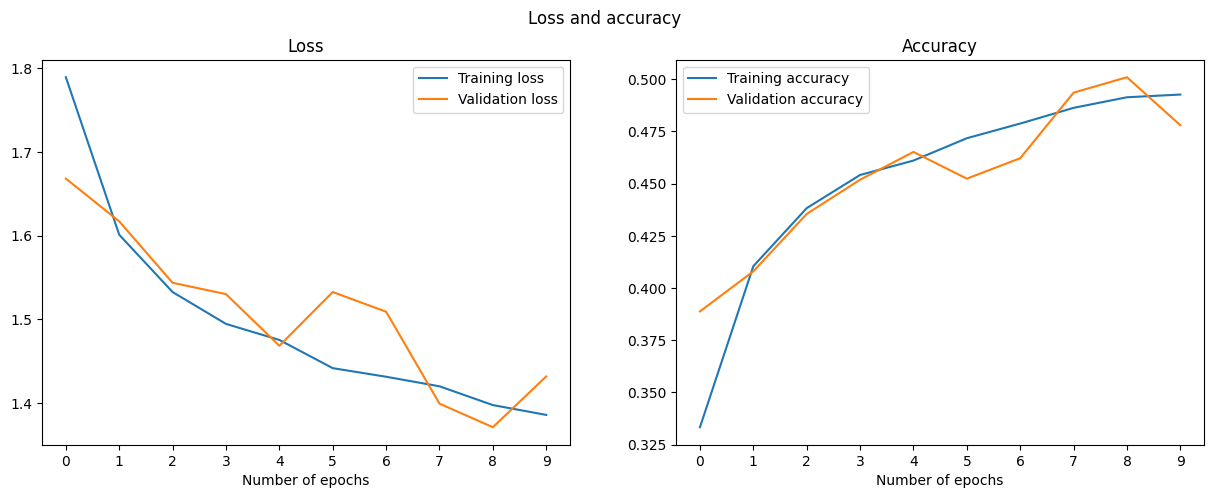

The test accuracy: 0.4707.  The test loss: 1.428847539923057.


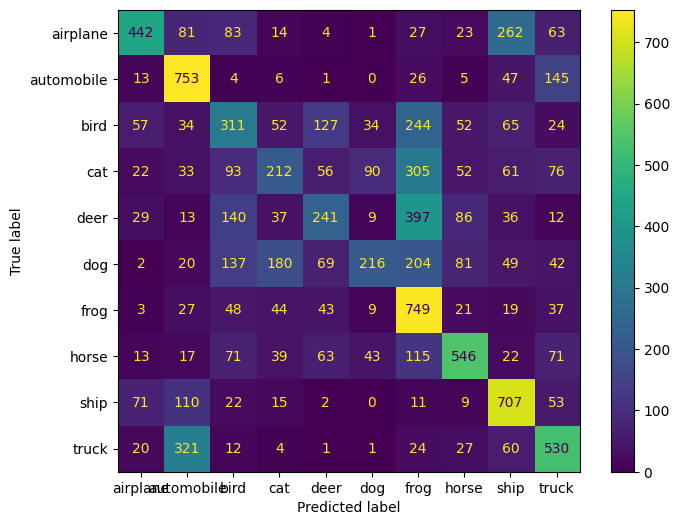

In [ ]:
network = Network(
        [Convolutional_layer(20, 3, 3), ReLU(), MaxPoolingLayer(), Convolutional_layer(15, 3, 20),
         ReLU(), MaxPoolingLayer(), Convolutional_layer(10, 3, 15), ReLU(), Convolutional_layer(6, 3, 10),
         ReLU(), MaxPoolingLayer(), Flatten(), Linear(96, 40), ReLU(), Linear(40, 10), SoftMax()])

network.batch_gradient_descent(x_train, y_train, x_test, y_test, 10, 64, 0.01)

Epoch: 1   Training loss: 1.8026072265625   Training accuracy: 0.335875   Validation loss: 1.5792307273884123   Validation accuracy: 0.4223
Epoch: 2   Training loss: 1.4906576171875   Training accuracy: 0.457175   Validation loss: 1.4372289785602723   Validation accuracy: 0.48
Epoch: 3   Training loss: 1.38200078125   Training accuracy: 0.5009   Validation loss: 1.3769453888933711   Validation accuracy: 0.5129
Epoch: 4   Training loss: 1.308594140625   Training accuracy: 0.5298   Validation loss: 1.2795821084889976   Validation accuracy: 0.5381
Epoch: 5   Training loss: 1.258821875   Training accuracy: 0.54755   Validation loss: 1.2924932614615632   Validation accuracy: 0.5372
Epoch: 6   Training loss: 1.21780078125   Training accuracy: 0.562725   Validation loss: 1.2138743827345184   Validation accuracy: 0.5577
Epoch: 7   Training loss: 1.18217568359375   Training accuracy: 0.578975   Validation loss: 1.2383921483636653   Validation accuracy: 0.5615
Epoch: 8   Training loss: 1.1551171

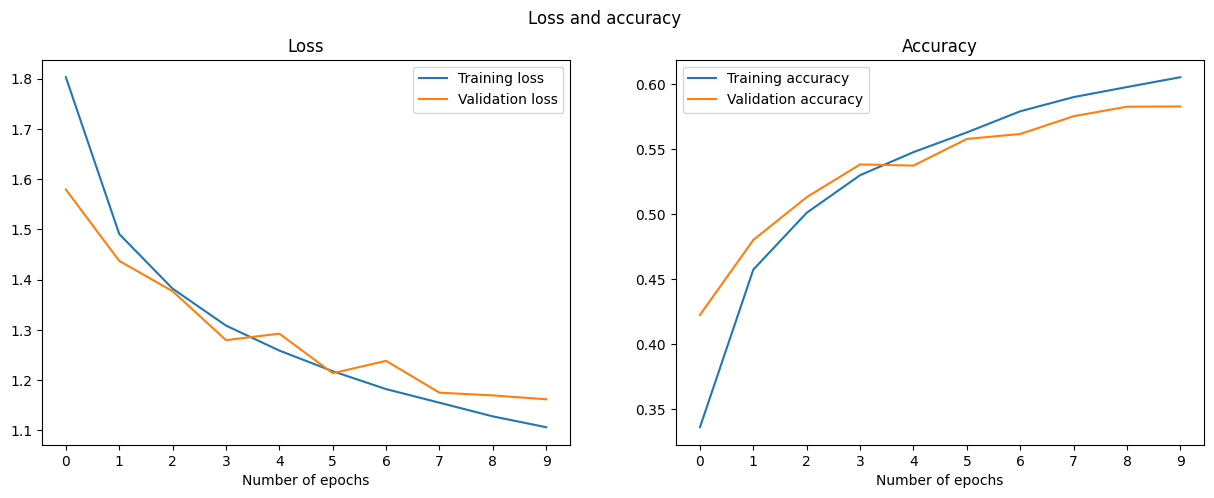

The test accuracy: 0.5861.  The test loss: 1.150120369818282.


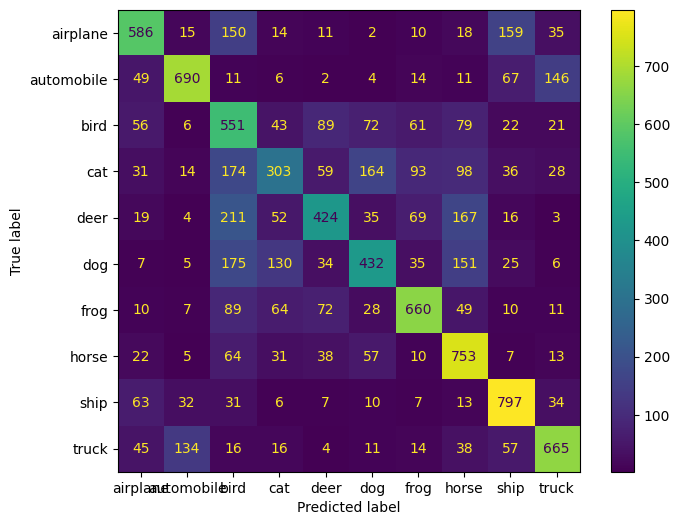

In [ ]:
network = Network(
        [Convolutional_layer(20, 3, 3), ReLU(), MaxPoolingLayer(), Convolutional_layer(15, 3, 20),
         ReLU(), MaxPoolingLayer(), Convolutional_layer(10, 3, 15), ReLU(), Convolutional_layer(6, 3, 10),
         ReLU(), MaxPoolingLayer(), Flatten(), Linear(96, 40), ReLU(), Linear(40, 10), SoftMax()])

network.batch_gradient_descent(x_train, y_train, x_test, y_test, 10, 64, 0.001)

Epoch: 1   Training loss: 1.9162359375   Training accuracy: 0.295575   Validation loss: 1.6520987487555168   Validation accuracy: 0.395
Epoch: 2   Training loss: 1.56652626953125   Training accuracy: 0.425325   Validation loss: 1.5013181167841751   Validation accuracy: 0.4537
Epoch: 3   Training loss: 1.459740234375   Training accuracy: 0.470575   Validation loss: 1.4603715511462632   Validation accuracy: 0.4728
Epoch: 4   Training loss: 1.39010517578125   Training accuracy: 0.4973   Validation loss: 1.3631544442199217   Validation accuracy: 0.5082
Epoch: 5   Training loss: 1.342748046875   Training accuracy: 0.51405   Validation loss: 1.3239928592955903   Validation accuracy: 0.5215
Epoch: 6   Training loss: 1.302875   Training accuracy: 0.5306   Validation loss: 1.291761361563334   Validation accuracy: 0.5367
Epoch: 7   Training loss: 1.272779296875   Training accuracy: 0.5416   Validation loss: 1.2636287051178887   Validation accuracy: 0.549
Epoch: 8   Training loss: 1.2423301757812

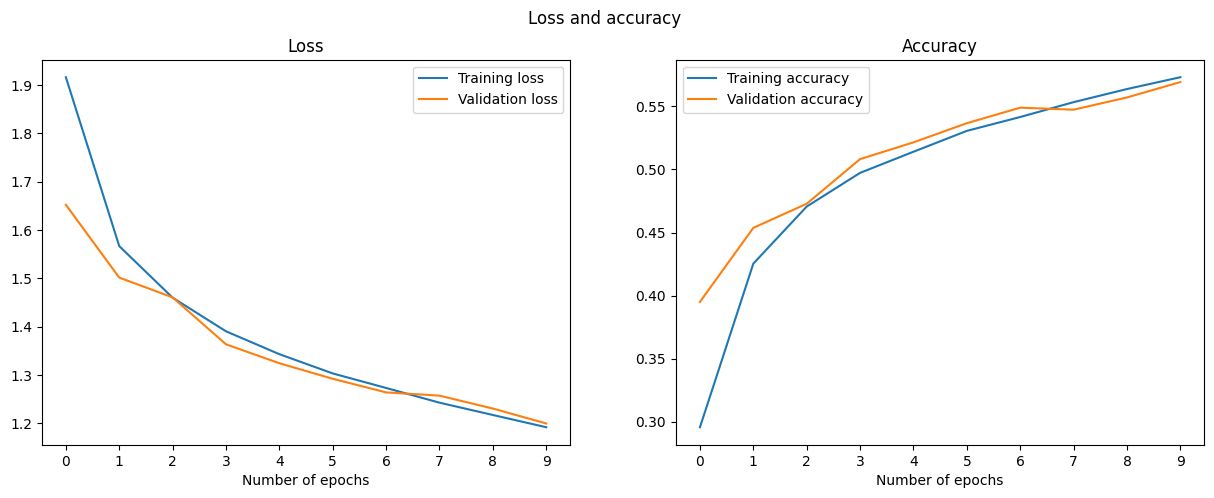

The test accuracy: 0.5659.  The test loss: 1.2037622725200223.


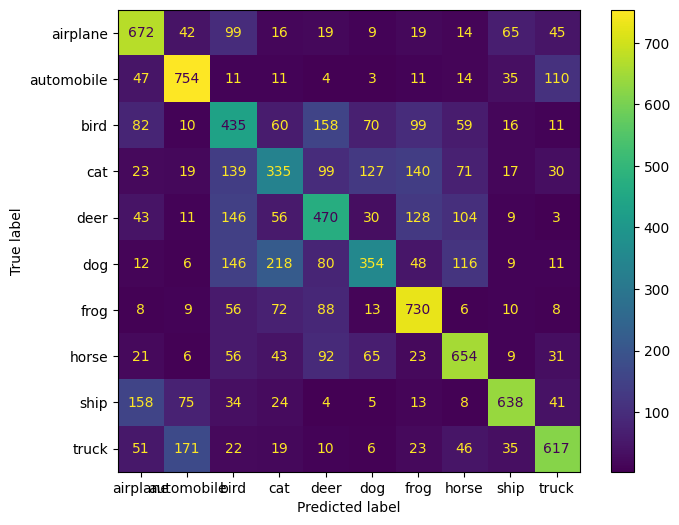

In [ ]:
network = Network(
        [Convolutional_layer(20, 3, 3), ReLU(), MaxPoolingLayer(), Convolutional_layer(15, 3, 20),
         ReLU(), MaxPoolingLayer(), Convolutional_layer(10, 3, 15), ReLU(), Convolutional_layer(6, 3, 10),
         ReLU(), MaxPoolingLayer(), Flatten(), Linear(96, 40), ReLU(), Linear(40, 10), SoftMax()])

network.batch_gradient_descent(x_train, y_train, x_test, y_test, 10, 64, 0.0005)

Epoch: 1   Training loss: 1.6597798828125   Training accuracy: 0.397975   Validation loss: 1.3952992166959541   Validation accuracy: 0.4984
Epoch: 2   Training loss: 1.292041796875   Training accuracy: 0.5386   Validation loss: 1.2779618750226476   Validation accuracy: 0.5545
Epoch: 3   Training loss: 1.1480333984375   Training accuracy: 0.5954   Validation loss: 1.1203337972409986   Validation accuracy: 0.6109
Epoch: 4   Training loss: 1.0583759765625   Training accuracy: 0.628575   Validation loss: 1.1282450618793742   Validation accuracy: 0.6028
Epoch: 5   Training loss: 0.99138466796875   Training accuracy: 0.65   Validation loss: 1.035843660753449   Validation accuracy: 0.635
Epoch: 6   Training loss: 0.935651171875   Training accuracy: 0.672275   Validation loss: 1.0475532751477752   Validation accuracy: 0.6329
Epoch: 7   Training loss: 0.89748759765625   Training accuracy: 0.68465   Validation loss: 0.9552613823156629   Validation accuracy: 0.6672
Epoch: 8   Training loss: 0.860

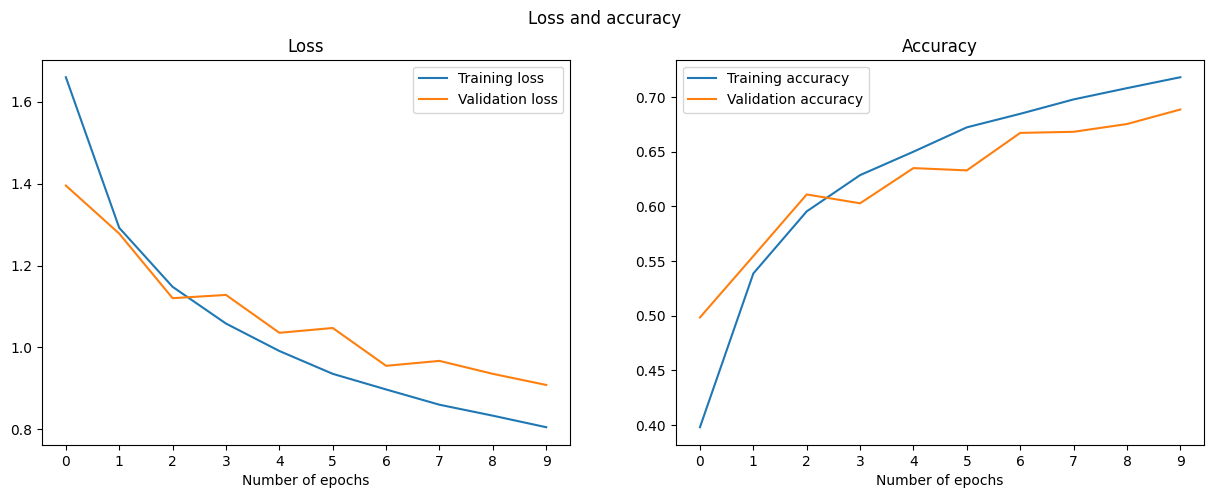

The test accuracy: 0.6884.  The test loss: 0.918142692032228.


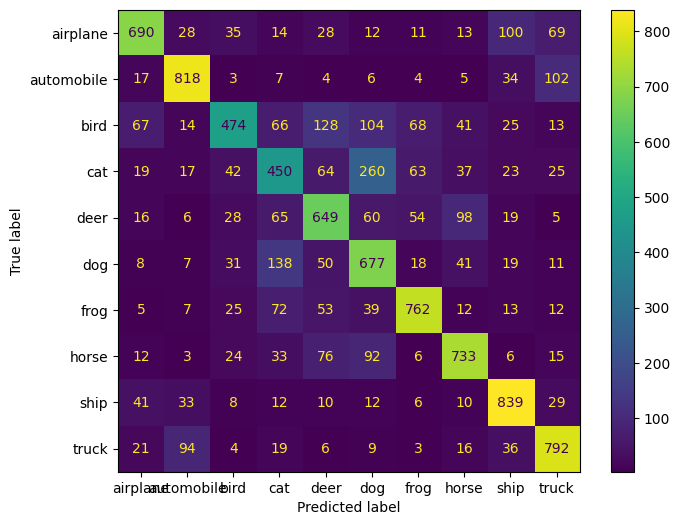

In [ ]:
network = Network(
        [Convolutional_layer(32, 3, 3), ReLU(), MaxPoolingLayer(), Convolutional_layer(24, 3, 32),
         ReLU(), MaxPoolingLayer(), Convolutional_layer(16, 3, 24), ReLU(), MaxPoolingLayer(),
         Flatten(), Linear(256, 64), ReLU(), Linear(64, 10), SoftMax()])

network.batch_gradient_descent(x_train, y_train, x_test, y_test, 10, 64, 0.001)

Epoch: 1   Training loss: 1.595652734375   Training accuracy: 0.416025   Validation loss: 1.3223982278109108   Validation accuracy: 0.5259
Epoch: 2   Training loss: 1.234617578125   Training accuracy: 0.559825   Validation loss: 1.1892491252262167   Validation accuracy: 0.5742
Epoch: 3   Training loss: 1.096301953125   Training accuracy: 0.6127   Validation loss: 1.1318690958886752   Validation accuracy: 0.6069
Epoch: 4   Training loss: 1.011404296875   Training accuracy: 0.643925   Validation loss: 1.0319375056952511   Validation accuracy: 0.6394
Epoch: 5   Training loss: 0.9482115234375   Training accuracy: 0.6686   Validation loss: 1.049876179515716   Validation accuracy: 0.6358
Epoch: 6   Training loss: 0.893622265625   Training accuracy: 0.686475   Validation loss: 0.9577965844983455   Validation accuracy: 0.667
Epoch: 7   Training loss: 0.8561208984375   Training accuracy: 0.7008   Validation loss: 0.9837983199118565   Validation accuracy: 0.6605
Epoch: 8   Training loss: 0.81845

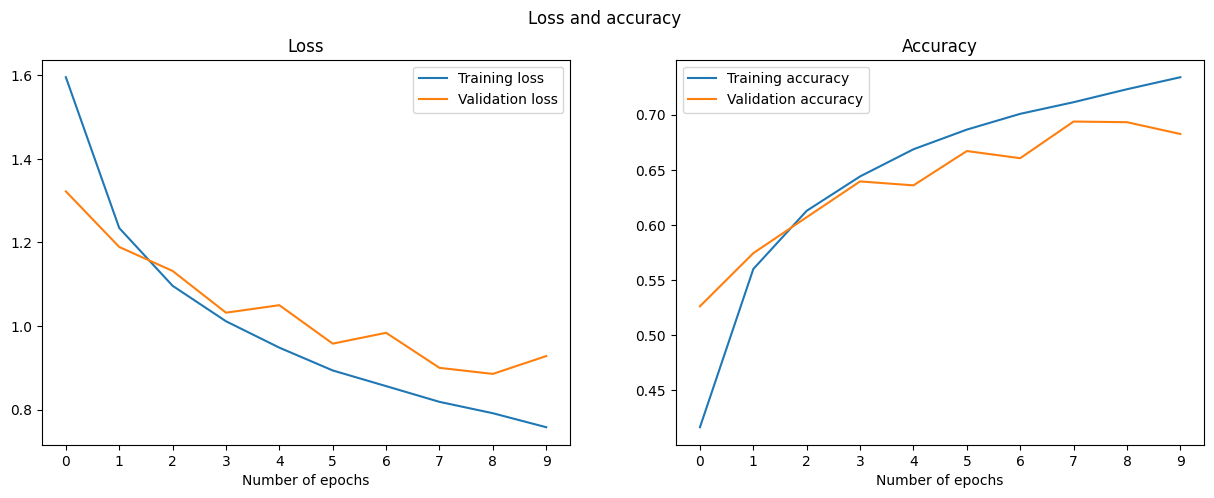

The test accuracy: 0.6765.  The test loss: 0.9417749083893721.


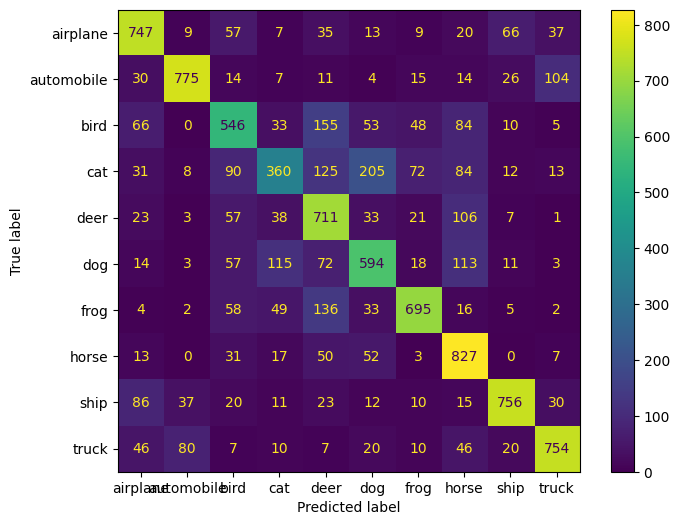

In [ ]:
network = Network(
        [Convolutional_layer(32, 3, 3), ReLU(), MaxPoolingLayer(), Convolutional_layer(32, 3, 32),
         ReLU(), MaxPoolingLayer(), Convolutional_layer(24, 3, 32), ReLU(), MaxPoolingLayer(),
         Flatten(), Linear(384, 64), ReLU(), Linear(64, 10), SoftMax()])

network.batch_gradient_descent(x_train, y_train, x_test, y_test, 10, 64, 0.001)

Epoch: 1   Training loss: 1.471859375   Training accuracy: 0.470475   Validation loss: 1.2128035780583923   Validation accuracy: 0.5716
Epoch: 2   Training loss: 1.073717578125   Training accuracy: 0.6189   Validation loss: 1.027599184291572   Validation accuracy: 0.6427
Epoch: 3   Training loss: 0.8997875   Training accuracy: 0.68465   Validation loss: 1.00548698882776   Validation accuracy: 0.6554
Epoch: 4   Training loss: 0.777585400390625   Training accuracy: 0.7265   Validation loss: 0.9314688773292097   Validation accuracy: 0.68
Epoch: 5   Training loss: 0.67250185546875   Training accuracy: 0.762725   Validation loss: 0.9232060390555764   Validation accuracy: 0.69
Epoch: 6   Training loss: 0.58096171875   Training accuracy: 0.795475   Validation loss: 0.9079746899947537   Validation accuracy: 0.7051
Epoch: 7   Training loss: 0.501342041015625   Training accuracy: 0.82505   Validation loss: 0.9377030551612179   Validation accuracy: 0.7002
Epoch: 8   Training loss: 0.418791015625 

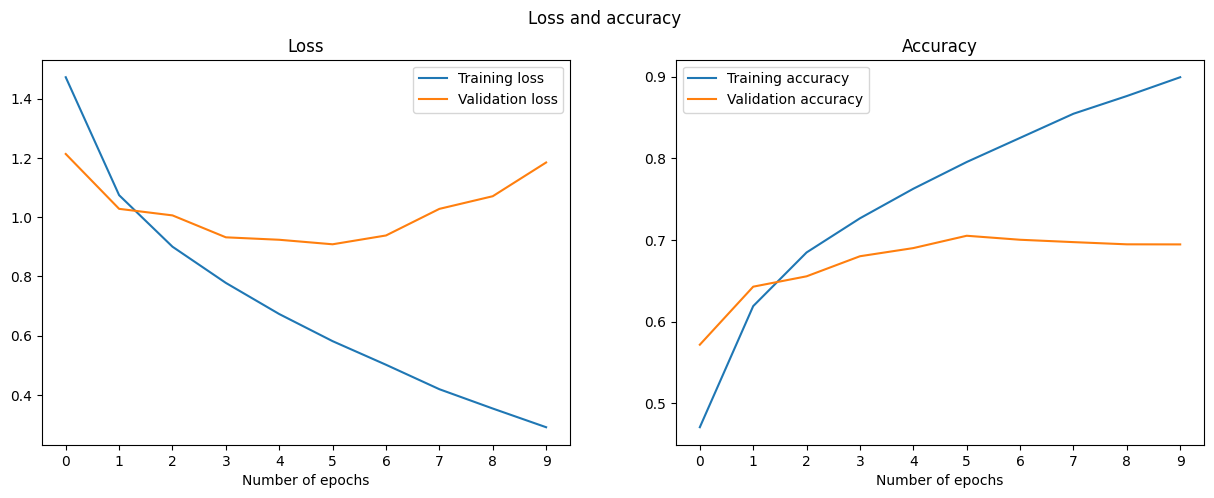

The test accuracy: 0.6913.  The test loss: 1.187287371229065.


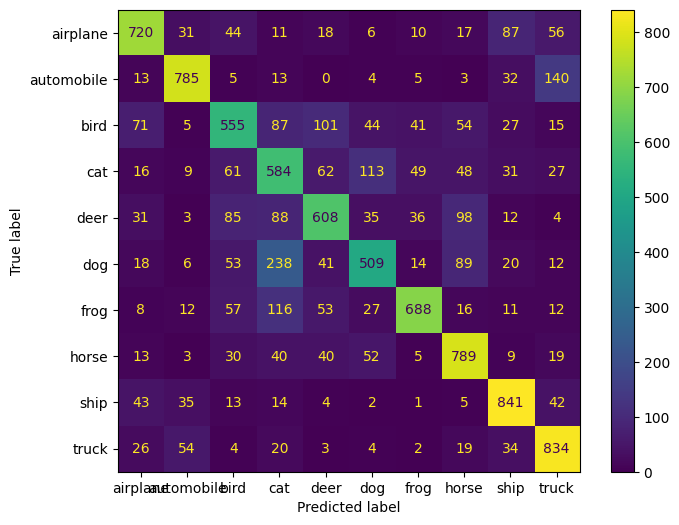

In [ ]:
network = Network(
        [Convolutional_layer(32, 3, 3), ReLU(), Convolutional_layer(32, 3, 32),
         ReLU(), MaxPoolingLayer(), Convolutional_layer(24, 3, 32), ReLU(), MaxPoolingLayer(),
         Flatten(), Linear(1536, 128), ReLU(), Linear(128, 10), SoftMax()])

network.batch_gradient_descent(x_train, y_train, x_test, y_test, 10, 64, 0.001)

Epoch: 1   Training loss: 1.3277505859375   Training accuracy: 0.529425   Validation loss: 1.0370706261926137   Validation accuracy: 0.6359
Epoch: 2   Training loss: 0.91916484375   Training accuracy: 0.676925   Validation loss: 0.9528041357301774   Validation accuracy: 0.6688
Epoch: 3   Training loss: 0.738197607421875   Training accuracy: 0.7421   Validation loss: 0.9322624847201311   Validation accuracy: 0.6823
Epoch: 4   Training loss: 0.5949107421875   Training accuracy: 0.79045   Validation loss: 0.8390464855531542   Validation accuracy: 0.7171
Epoch: 5   Training loss: 0.459521728515625   Training accuracy: 0.8376   Validation loss: 0.872290118934082   Validation accuracy: 0.7189
Epoch: 6   Training loss: 0.32853486328125   Training accuracy: 0.887875   Validation loss: 0.9705111400971855   Validation accuracy: 0.7215
Epoch: 7   Training loss: 0.2365813720703125   Training accuracy: 0.917125   Validation loss: 1.0993543164307973   Validation accuracy: 0.7169
Epoch: 8   Training 

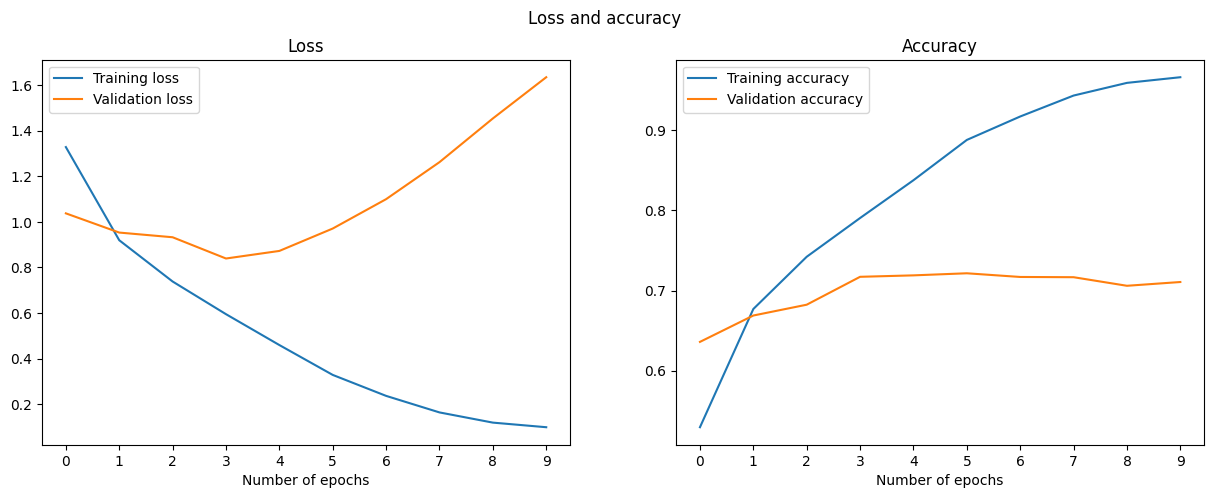

The test accuracy: 0.7124.  The test loss: 1.6138138113272285.


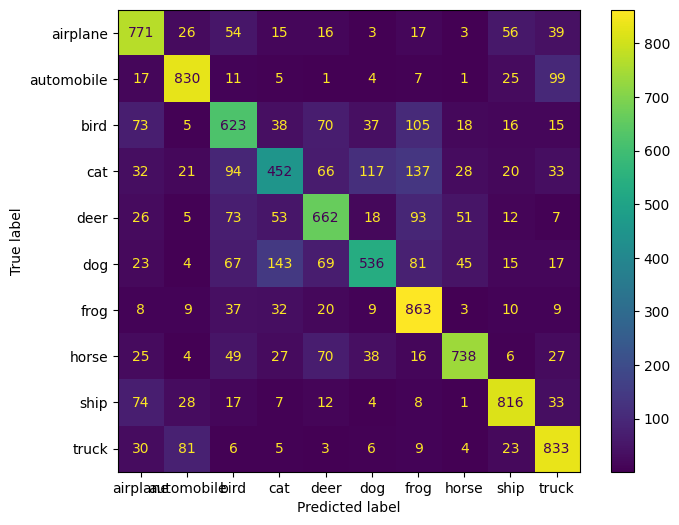

In [ ]:
network = Network(
        [Convolutional_layer(32, 3, 3), ReLU(), Convolutional_layer(48, 3, 32),
         ReLU(), MaxPoolingLayer(), Convolutional_layer(64, 3, 48), ReLU(), MaxPoolingLayer(),
         Flatten(), Linear(4096, 256), ReLU(), Linear(256, 10), SoftMax()])

network.batch_gradient_descent(x_train, y_train, x_test, y_test, 10, 64, 0.001)

Epoch: 1   Training loss: 1.4663537109375   Training accuracy: 0.4731   Validation loss: 1.2233545327427933   Validation accuracy: 0.5708
Epoch: 2   Training loss: 1.0651236328125   Training accuracy: 0.625775   Validation loss: 1.0054684477183866   Validation accuracy: 0.6523
Epoch: 3   Training loss: 0.9019322265625   Training accuracy: 0.68545   Validation loss: 0.9232444517070236   Validation accuracy: 0.6795
Epoch: 4   Training loss: 0.80127724609375   Training accuracy: 0.7204   Validation loss: 0.8677898550795613   Validation accuracy: 0.6987
Epoch: 5   Training loss: 0.711881640625   Training accuracy: 0.75035   Validation loss: 0.8629360780033692   Validation accuracy: 0.6997
Epoch: 6   Training loss: 0.64635390625   Training accuracy: 0.77245   Validation loss: 0.8424254914815498   Validation accuracy: 0.7081
Epoch: 7   Training loss: 0.579333447265625   Training accuracy: 0.79795   Validation loss: 0.8721331818440683   Validation accuracy: 0.7123
Epoch: 8   Training loss: 0.

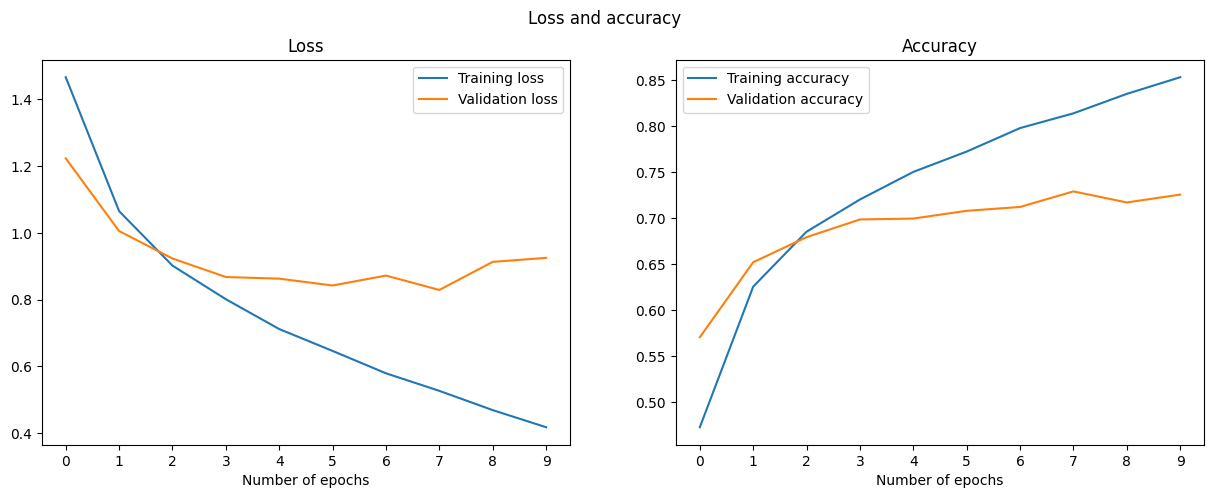

The test accuracy: 0.7255.  The test loss: 0.9270441158795496.


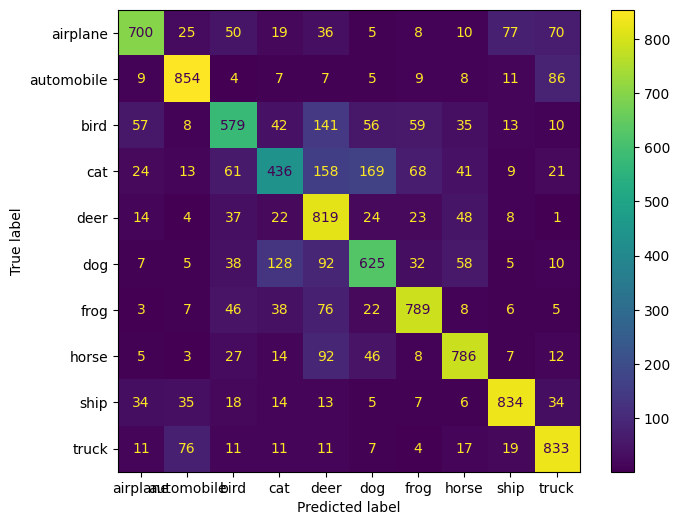

In [ ]:
network = Network(
        [Convolutional_layer(32, 3, 3), ReLU(), MaxPoolingLayer(), Convolutional_layer(48, 3, 32),
         ReLU(), MaxPoolingLayer(), Convolutional_layer(64, 3, 48), ReLU(), MaxPoolingLayer(),
         Flatten(), Linear(1024, 128), ReLU(), Linear(128, 10), SoftMax()])

network.batch_gradient_descent(x_train, y_train, x_test, y_test, 10, 64, 0.001)

Epoch: 1   Training loss: 1.78693125   Training accuracy: 0.352375   Validation loss: 1.3693977550409384   Validation accuracy: 0.5358
Epoch: 2   Training loss: 1.4283154296875   Training accuracy: 0.471025   Validation loss: 1.0537225743283496   Validation accuracy: 0.6513
Epoch: 3   Training loss: 1.2642130859375   Training accuracy: 0.532325   Validation loss: 0.9632842582060607   Validation accuracy: 0.6831
Epoch: 4   Training loss: 1.14042587890625   Training accuracy: 0.578675   Validation loss: 0.8894714746793682   Validation accuracy: 0.6975
Epoch: 5   Training loss: 1.0462435546875   Training accuracy: 0.608975   Validation loss: 0.846616726223587   Validation accuracy: 0.7152
Epoch: 6   Training loss: 0.95157734375   Training accuracy: 0.64315   Validation loss: 0.820136092493254   Validation accuracy: 0.7181
Epoch: 7   Training loss: 0.878478125   Training accuracy: 0.6706   Validation loss: 0.8273527916168114   Validation accuracy: 0.7245
Epoch: 8   Training loss: 0.8171262

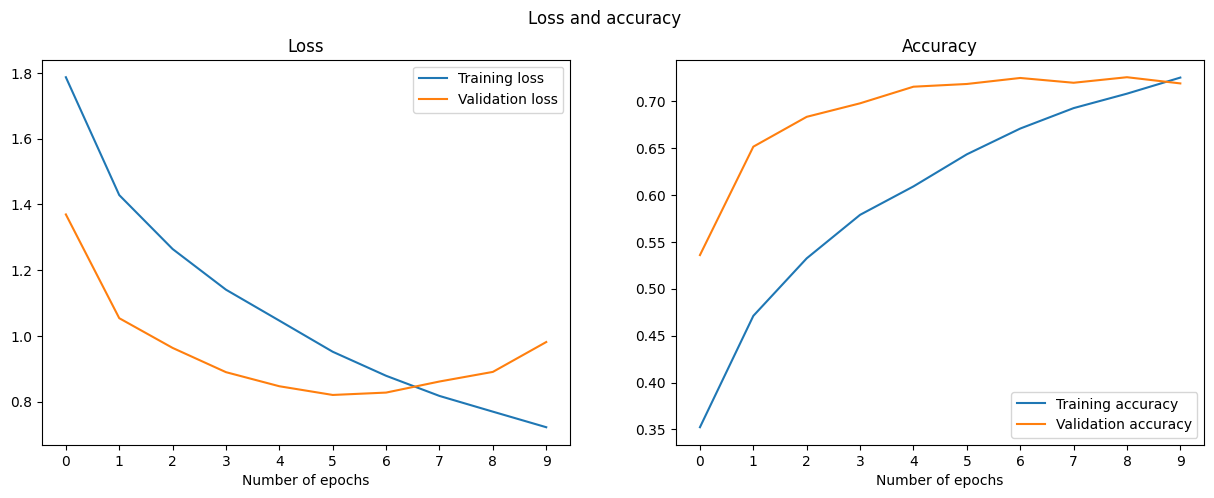

The test accuracy: 0.7084.  The test loss: 1.0290686984563542.


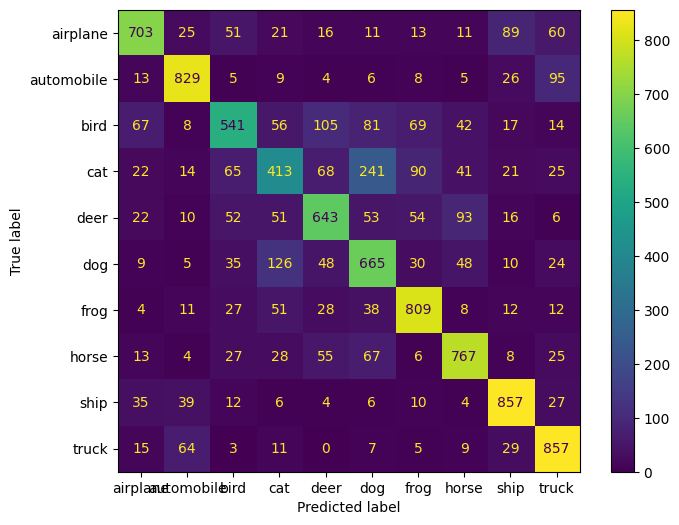

In [ ]:
network = Network(
        [Convolutional_layer(32, 3, 3), ReLU(), Dropout(0.15), Convolutional_layer(48, 3, 32),
         ReLU(), MaxPoolingLayer(), Convolutional_layer(64, 3, 48), ReLU(), MaxPoolingLayer(),
         Flatten(), Linear(4096, 256), ReLU(), Dropout(0.25), Linear(256, 10), SoftMax()])

network.batch_gradient_descent(x_train, y_train, x_test, y_test, 10, 64, 0.001)

Epoch: 1   Training loss: 1.8569953125   Training accuracy: 0.316375   Validation loss: 1.4356735271755092   Validation accuracy: 0.4943
Epoch: 2   Training loss: 1.5131392578125   Training accuracy: 0.437525   Validation loss: 1.1699423814829506   Validation accuracy: 0.5975
Epoch: 3   Training loss: 1.3602044921875   Training accuracy: 0.4929   Validation loss: 1.0130652231401818   Validation accuracy: 0.6607
Epoch: 4   Training loss: 1.2519341796875   Training accuracy: 0.53095   Validation loss: 0.9542776704707802   Validation accuracy: 0.6781
Epoch: 5   Training loss: 1.174633984375   Training accuracy: 0.5584   Validation loss: 0.881684336650445   Validation accuracy: 0.6964
Epoch: 6   Training loss: 1.091158984375   Training accuracy: 0.5909   Validation loss: 0.8692212995204344   Validation accuracy: 0.6982
Epoch: 7   Training loss: 1.02150712890625   Training accuracy: 0.616925   Validation loss: 0.8658883786908538   Validation accuracy: 0.7038
Epoch: 8   Training loss: 0.9696

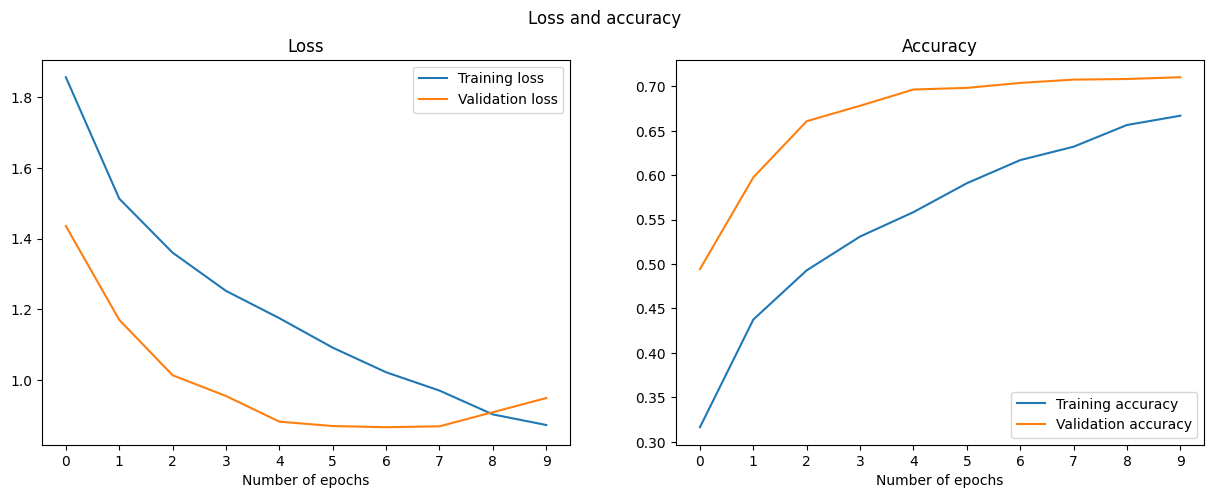

The test accuracy: 0.7023.  The test loss: 0.9742448359633998.


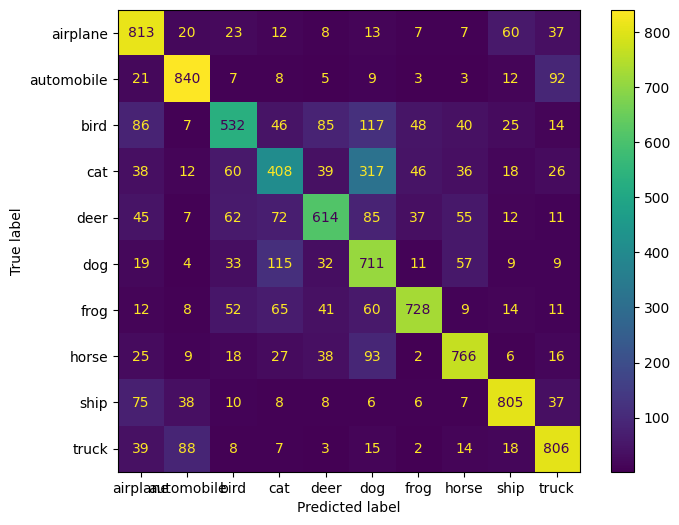

In [ ]:
network = Network(
        [Convolutional_layer(32, 3, 3), ReLU(), Dropout(0.20), Convolutional_layer(48, 3, 32),
         ReLU(), MaxPoolingLayer(), Convolutional_layer(64, 3, 48), ReLU(), MaxPoolingLayer(),
         Flatten(), Linear(4096, 256), ReLU(), Dropout(0.30), Linear(256, 10), SoftMax()])

network.batch_gradient_descent(x_train, y_train, x_test, y_test, 10, 64, 0.001)

Epoch: 1   Training loss: 1.901475   Training accuracy: 0.29235   Validation loss: 1.569792526308756   Validation accuracy: 0.5369
Epoch: 2   Training loss: 1.6200666015625   Training accuracy: 0.393375   Validation loss: 1.2620458260356744   Validation accuracy: 0.6054
Epoch: 3   Training loss: 1.514191796875   Training accuracy: 0.4321   Validation loss: 1.0780560197591127   Validation accuracy: 0.6508
Epoch: 4   Training loss: 1.41727646484375   Training accuracy: 0.466175   Validation loss: 0.9987992678128755   Validation accuracy: 0.6915
Epoch: 5   Training loss: 1.352721484375   Training accuracy: 0.4898   Validation loss: 0.9275879850854979   Validation accuracy: 0.6956
Epoch: 6   Training loss: 1.29542265625   Training accuracy: 0.508975   Validation loss: 0.9191584893886342   Validation accuracy: 0.6933
Epoch: 7   Training loss: 1.2515744140625   Training accuracy: 0.523775   Validation loss: 0.8385944945427382   Validation accuracy: 0.7242
Epoch: 8   Training loss: 1.19248066

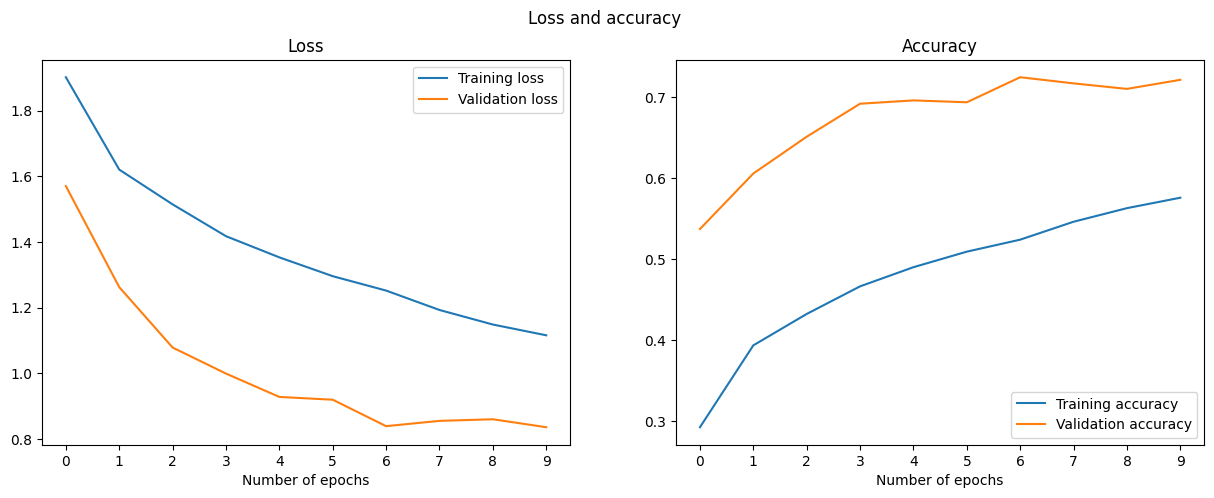

The test accuracy: 0.7075.  The test loss: 0.8509841340258985.


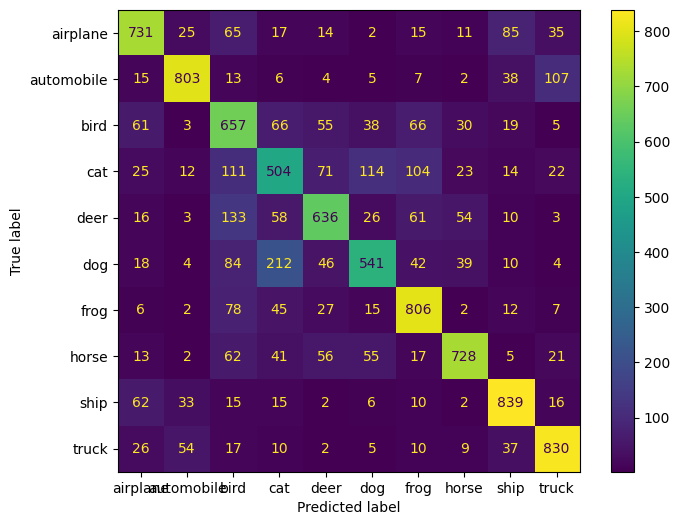

In [ ]:
network = Network(
        [Convolutional_layer(32, 3, 3), ReLU(), Dropout(0.15), Convolutional_layer(48, 3, 32), Dropout(0.15),
         ReLU(), MaxPoolingLayer(), Convolutional_layer(64, 3, 48), ReLU(), MaxPoolingLayer(),
         Flatten(), Linear(4096, 256), ReLU(), Dropout(0.40), Linear(256, 10), SoftMax()])

network.batch_gradient_descent(x_train, y_train, x_test, y_test, 10, 64, 0.001)

Epoch: 1   Training loss: 1.8124919921875   Training accuracy: 0.338425   Validation loss: 1.4218119930392301   Validation accuracy: 0.5214
Epoch: 2   Training loss: 1.4474958984375   Training accuracy: 0.463325   Validation loss: 1.155845755466441   Validation accuracy: 0.6185
Epoch: 3   Training loss: 1.2973123046875   Training accuracy: 0.521475   Validation loss: 1.044233714824387   Validation accuracy: 0.6531
Epoch: 4   Training loss: 1.19082412109375   Training accuracy: 0.56055   Validation loss: 0.9300835971168537   Validation accuracy: 0.6846
Epoch: 5   Training loss: 1.08752490234375   Training accuracy: 0.596   Validation loss: 0.8928009178363141   Validation accuracy: 0.6934
Epoch: 6   Training loss: 1.01141328125   Training accuracy: 0.62325   Validation loss: 0.894417982016265   Validation accuracy: 0.6947
Epoch: 7   Training loss: 0.9254966796875   Training accuracy: 0.65325   Validation loss: 0.8886804859349929   Validation accuracy: 0.6968
Epoch: 8   Training loss: 0.8

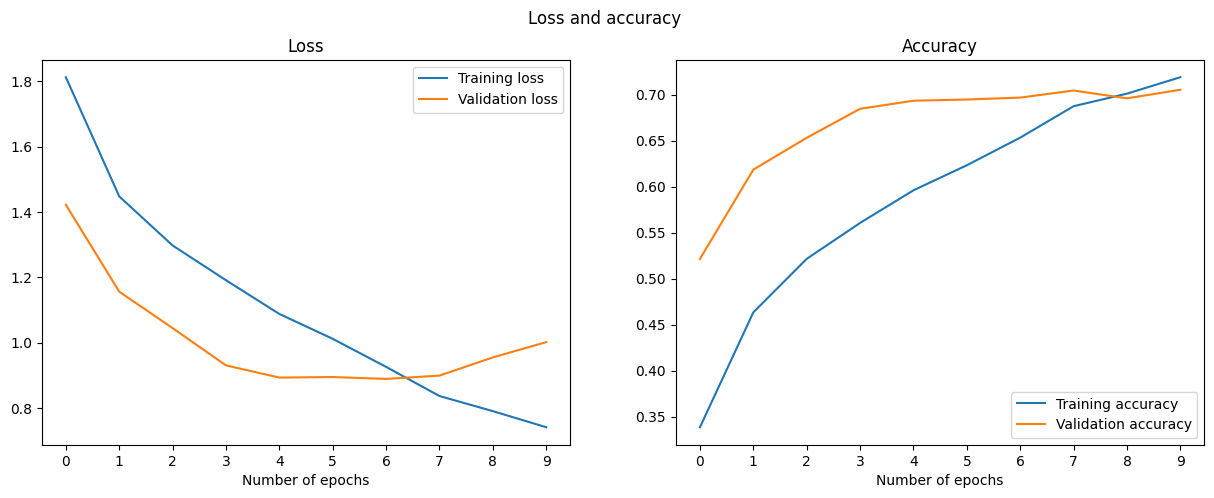

The test accuracy: 0.697.  The test loss: 1.0057700039947475.


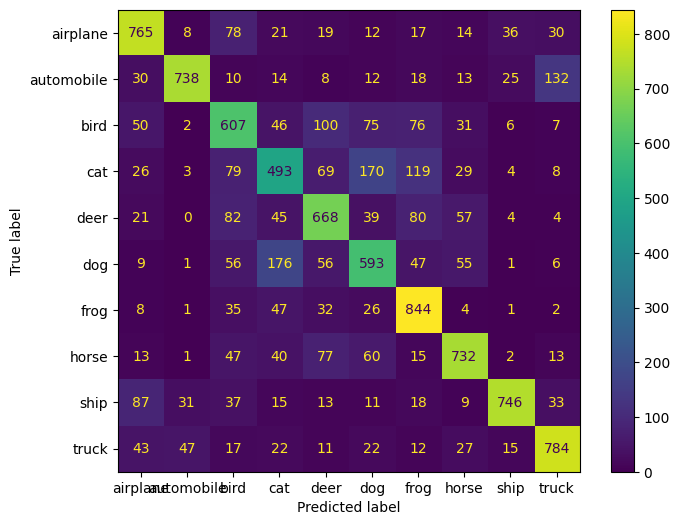

In [ ]:
network = Network(
        [Convolutional_layer(32, 3, 3), ReLU(), Dropout(0.10), Convolutional_layer(48, 3, 32),
         ReLU(), Dropout(0.10), MaxPoolingLayer(), Convolutional_layer(64, 3, 48), ReLU(), MaxPoolingLayer(),
         Flatten(), Linear(4096, 256), ReLU(), Dropout(0.25), Linear(256, 10), SoftMax()])

network.batch_gradient_descent(x_train, y_train, x_test, y_test, 10, 64, 0.001)

Epoch: 1   Training loss: 1.52285947265625   Training accuracy: 0.450675   Validation loss: 1.2534697504617338   Validation accuracy: 0.5586
Epoch: 2   Training loss: 1.10846044921875   Training accuracy: 0.6081   Validation loss: 1.0607502281593713   Validation accuracy: 0.6385
Epoch: 3   Training loss: 0.9467228515625   Training accuracy: 0.66885   Validation loss: 0.954753189037686   Validation accuracy: 0.6722
Epoch: 4   Training loss: 0.83748134765625   Training accuracy: 0.70885   Validation loss: 0.8917353993743472   Validation accuracy: 0.691
Epoch: 5   Training loss: 0.74850068359375   Training accuracy: 0.739325   Validation loss: 0.8606912472644639   Validation accuracy: 0.7057
Epoch: 6   Training loss: 0.680960546875   Training accuracy: 0.7596   Validation loss: 0.8506677185309669   Validation accuracy: 0.7125
Epoch: 7   Training loss: 0.6288419921875   Training accuracy: 0.779025   Validation loss: 0.8499176692458875   Validation accuracy: 0.7137
Epoch: 8   Training loss:

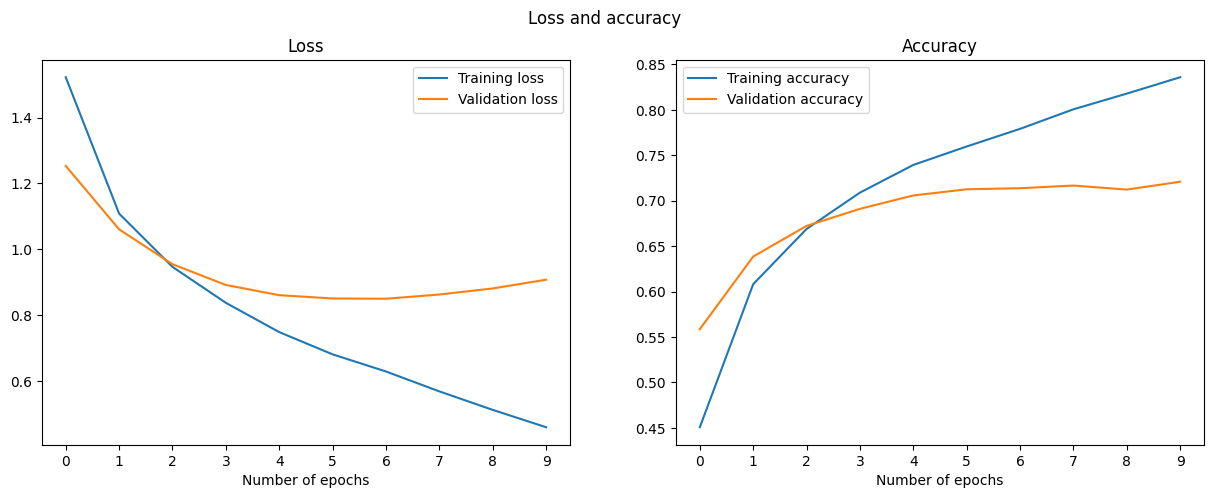

The test accuracy: 0.7106.  The test loss: 0.9326523570002963.


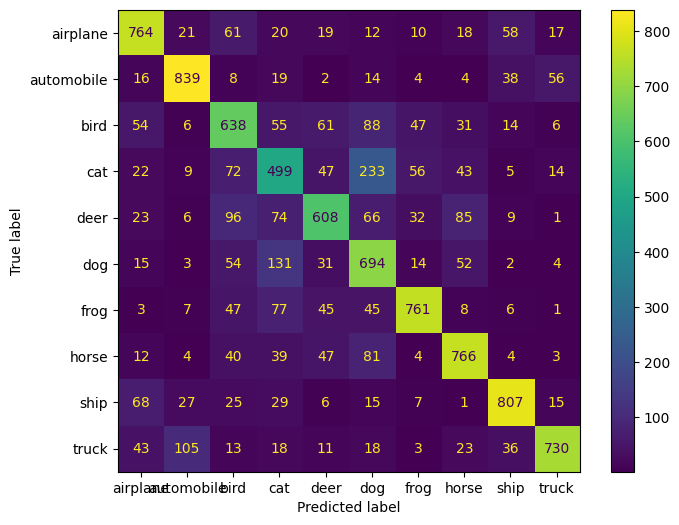

In [ ]:
network = Network(
        [Convolutional_layer(32, 3, 3), ReLU(), MaxPoolingLayer(), Convolutional_layer(48, 3, 32),
         ReLU(), MaxPoolingLayer(), Convolutional_layer(64, 3, 48), ReLU(), MaxPoolingLayer(),
         Flatten(), Linear(1024, 128), ReLU(), Linear(128, 10), SoftMax()])

network.batch_gradient_descent(x_train, y_train, x_test, y_test, 10, 64, 0.001)